<a href="https://colab.research.google.com/github/kidninja23/learn-co-sandbox/blob/master/MTGValuer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project MTG Card Valuer Part One**

**Goal**: Train a neural network that can estimate the value of individual Magic the Gathering (MTG) cards based on card text. 

**Card Structure**: MTG cards have several features that determine the overall effrectiveness of the card within the game. The following diagram describes the basic card structure. 

![alt text](https://www.researchgate.net/profile/Leda_Tomitch/publication/323978136/figure/fig2/AS:607539402121222@1521860089805/Parts-of-a-card.png)

*Filho, Raimundo & Tomitch, Leda. (2018). The use of the game Magic: The Gathering in the teaching of L2 reading. Letrônica. 10. 775. 10.15448/1984-4301.2017.2.26398. 

<br>
**Conditions**: This version of the MTG Card Valuer project deals only with the card text portion of each card. All card features outside of the text box are ignored in part one of the valuer project. All flavor text is ignored.

<br>
**Text Objects**: The card valuer recognizes multiple card text objects. Each object type contributes to the estimated card value. Objects include Static Abilities, Triggered Abilities, and Activated Abilities. The sum of each text object is calcualted as part of the value estimator function. 

<br>
**Definitions**:

Static: any continuous ability. Examples include Flying, First Strike, Defender, etc. 
<br><br>
Triggered: any action that occurs as a result of the card entering play or a condtion being met. 
<br><br>
Activated: any effect that can be triggered by paying any type of cost. 
<br><br>
Sphere of Influence: all areas a player can interact with. The default sphere of influence is the players hand, all cards the player controls on the battlefield, and the players library. Sphere of influence can be increased or decreased by playing cards. 
<br><br>
Card Advantage: The total number of cards in play after an action minus the number of cards in play prior to an action. 
<br><br>
Combo Score: The Combo Score is a composite value based on several factors. The score is generated based on the following values: 
*  Land Type +1.5 
*   Creature Type +1.0 
*  Life Gain +0.5 
*  Continuous Control Effect +0.5 
*  Temporary control effect +0.25 
*  Ongong effect +0.5 
*  Creature Removal +1.0 
*  Counter Spell +0.5 
*  Additional Resource Cost -0.5 
*  Conditional Behavior -0.5 
*  Combination Behavior +0.5
<br>

<br>
**Card Value**: All card values are dependent on the game format the card will be used in. For this project estimates are based on card usage in the Limited format. Limited formats require players to build decks of cards from a reduced pool of available cards. Within the limited format, the most highly valued cards are those that can be used in multiple game scenarios. 
<br>
The card value is estimated based on the text objects and two additional calcualted values, Card Advantage and Combo Score.
The complete value function for part one of the project is 
$V = 5S+8T+7A+10C_1+9C_2$
<br><br>
This value is only an estimation at this time. The value approximates professional estimates by well established sources such as ChannelFireball.com but is not yet a direct correlation to a complete card estimate. This value formulation does not take into account card costs or type. These two features contribute to human card estimates in subtle ways that are affected by play experience.

**Neural Network**:
The neural network trained here accepts the five numeric inputs and attempts to determine what the estimated value would be. The network uses linear regression techniques to determine how the datapoints estimate the card value. 
<br><br>
The next portions of this notebook walk through the training and test process. 



In [0]:
# Use seaborn for pairplot
!pip install -q seaborn

In [166]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

#tf.enable_eager_execution()

print(tf.__version__)

1.13.1


The following code connects the project to the datasets stored on my Google Drive. This connection must be remounted after a 24 hour period elapses. 

In [169]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


The below code snippet imports the training data set and assigns it to the dataset variable. The dataset includes 435 data points. This data was collected and perepared by calculating each of the five variables of the Value Estimation algorithm.  

**Data Processing**:<br>
Complete sets of all card data were collected in .json format from the MTGJSON project. Complete details about this project are available at the [mtgjson homepage](https://mtgjson.com)
<br><br>
The collected json data files were then scrubbed and converted to a csv format. The following python code was used to facilated that conversion:


```

import sys
import json
import csv

def to_string(s):
    try:
        return str(s)
    except:
        #Change the encoding type if needed
        return s.encode('utf-8')

def reduce_item(key, value):
    global reduced_item
    
    #Reduction Condition 1
    if type(value) is list:
        i=0
        for sub_item in value:
            reduce_item(key+'_'+to_string(i), sub_item)
            i=i+1

    #Reduction Condition 2
    elif type(value) is dict:
        sub_keys = value.keys()
        for sub_key in sub_keys:
            reduce_item(key+'_'+to_string(sub_key), value[sub_key])
    
    #Base Condition
    else:
        reduced_item[to_string(key)] = to_string(value)


if __name__ == "__main__":
    if len(sys.argv) != 4:
        print ("\nUsage: python json_to_csv.py <node_name> <json_in_file_path> <csv_out_file_path>\n")
    else:
        #Reading arguments
        node = sys.argv[1]
        json_file_path = sys.argv[2]
        csv_file_path = sys.argv[3]

        fp = open(json_file_path, 'r')
        json_value = fp.read()
        raw_data = json.loads(json_value)
        fp.close()
        
        try:
            data_to_be_processed = raw_data[node]
        except:
            data_to_be_processed = raw_data

        processed_data = []
        header = []
        for item in data_to_be_processed:
            reduced_item = {}
            reduce_item(node, item)

            header += reduced_item.keys()

            processed_data.append(reduced_item)

        header = list(set(header))
        header.sort()

        with open(csv_file_path, 'w+') as f:
            writer = csv.DictWriter(f, header, quoting=csv.QUOTE_ALL)
            writer.writeheader()
            for row in processed_data:
                writer.writerow(row)

        print ("Just completed writing csv file with %d columns" % len(header))
```

After conversion to a CSV file, the text for each card was converted directly into the five estimation variables. This conversion was the most time consuming part of this project. A follow up to this project would automate this process using additional text recognition to evaluate the variables without needed human input. 

A portion of the data set is printed out for user inspection.

In [179]:
column_names = ['Static Count', 'Triggered Count', 'Activated Count', 'Card Advantage', 'Combo Score','Text Score', 'Pro Score'] 


dataset_path = "/content/gdrive/My Drive/Colab Notebooks/Training_Set_3.csv"
dataset_path

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head(10)



,Static Count,Triggered Count,Activated Count,Card Advantage,Combo Score,Text Score,Pro Score
0,0.0,2.0,0.0,0.0,0.5,20.5,20.0
1,0.0,1.0,0.0,0.0,0.5,12.5,15.0
2,1.0,0.0,1.0,0.0,1.0,21.0,30.0
3,0.0,1.0,0.0,0.0,1.0,17.0,35.0
4,2.0,1.0,1.0,0.0,1.0,34.0,45.0
5,0.0,1.0,0.0,0.0,1.0,17.0,30.0
6,0.0,1.5,0.0,1.0,1.0,31.0,30.0
7,1.0,1.0,0.0,0.0,0.5,17.5,10.0
8,0.0,1.5,0.0,0.5,1.0,26.0,30.0
9,0.0,1.5,0.0,0.0,1.0,21.0,25.0


The Pro Score above represents a professional evaluation. This included values show how accurate our value estimation function is to professional evaluations , but it is not used in any further portion of thie project. <br><br>

The code below removes the Pick Score values from the data set. The dataset is then seperated into a training set to learn our data and a test set for evaluating the accuracy of the generated model. 

The value estimation function is fairly simple and should not require a large dataset to minimize error. 

In [0]:
dataset.pop('Pro Score')
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

The code below takes advantage of TensorFlows built in graphing techniques to visualize the data set relationships. 

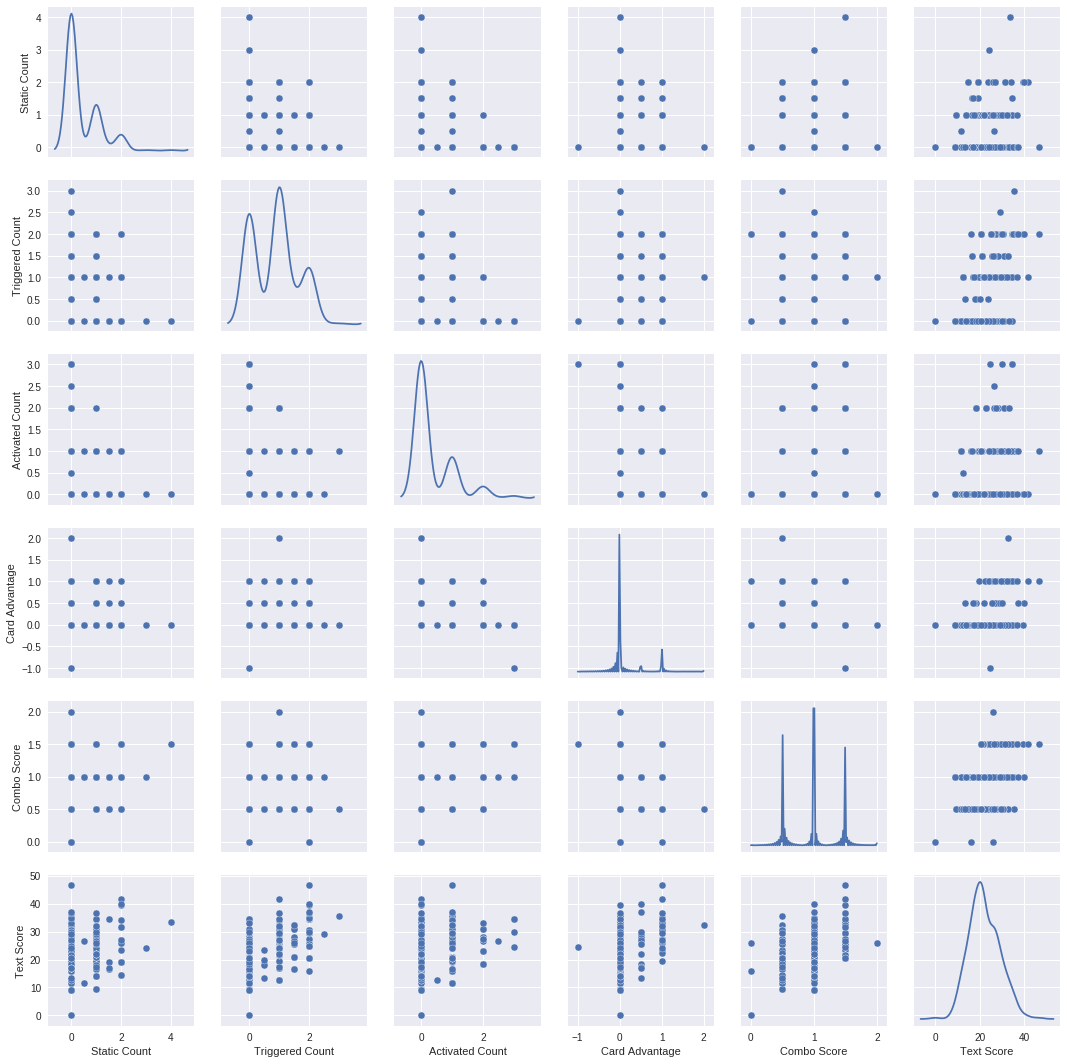

In [181]:
sns.pairplot(train_dataset[['Static Count', 'Triggered Count', 'Activated Count', 'Card Advantage', 'Combo Score','Text Score']], diag_kind="kde")

The below code snippet gives us information about each card feature within the dataset. 

In [182]:
train_stats = train_dataset.describe()
train_stats.pop("Text Score")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Static Count,348.0,0.423851,0.679532,0.0,0.0,0.0,1.0,4.0
Triggered Count,348.0,0.860632,0.724202,0.0,0.0,1.0,1.0,3.0
Activated Count,348.0,0.376437,0.660073,0.0,0.0,0.0,1.0,3.0
Card Advantage,348.0,0.159483,0.365669,-1.0,0.0,0.0,0.0,2.0
Combo Score,348.0,0.981322,0.346363,0.0,1.0,1.0,1.0,2.0


The Text Score is removed from both the training and testing datasets. This is dones so that the data does not contaminate the system by providing the value we are attempting to estimate. 

In [0]:
train_labels = train_dataset.pop('Text Score')
test_labels = test_dataset.pop('Text Score')

The data may converge without additional normalization, but by normalizing the data we will be able to more quickly traing our system. The code below defines our process of normalization for each data set. 

Normalize values are then output or provide the user with verification that the dataset has been updated. 

In [184]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.head(5)

,Static Count,Triggered Count,Activated Count,Card Advantage,Combo Score
153,2.319463,0.192443,-0.570295,-0.43614,1.497500
264,0.847862,0.192443,-0.570295,-0.43614,0.053927
54,-0.623739,1.573273,-0.570295,-0.43614,0.053927
355,2.319463,-1.188387,-0.570295,-0.43614,1.497500
428,-0.623739,0.192443,-0.570295,-0.43614,1.497500


The model below will set up the structure of our neural network. The network includes multiple dense layers and a hidden layer. The Optimizer utilizes the Root Mean Square algorithm. RMSprop is a built in function of Keras api. 

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model



After defining our model we use the built in build_model method to create it. 

In [0]:
model = build_model()

A summary of the model appears below. 

In [187]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


It can be useful to verify that we are going to be using valid data. The code snippet below provides us with a look at a portion of the data that will be used by the model to create our output. 

In [188]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.24157807],
       [-0.13860077],
       [-0.2988789 ],
       [-0.20106441],
       [-0.34125686],
       [-0.4848344 ],
       [-0.1071409 ],
       [-0.1071409 ],
       [-0.40232357],
       [-0.5144892 ]], dtype=float32)

We are now ready to run our neuarl network. Note that we have defined an early stop feature. This feature is used to prevent an overfitting of the model. 

We then print the result of our neural network. 


....................................................................................................
...................................................

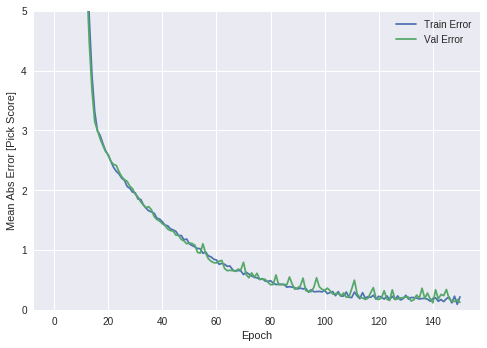

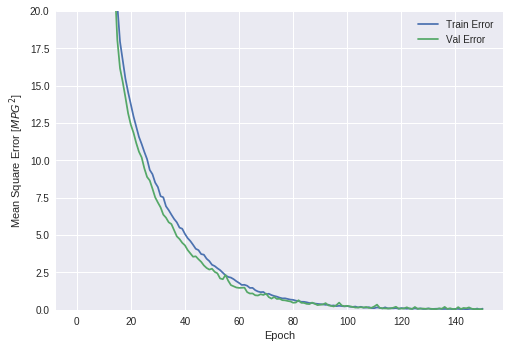

In [189]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

After roughly 150 epochs of training the data, the training is completed. As explected the absolute error above is shown to be extremely low. The code below shows the exact Mean Absolute Error after training our network. 

In [190]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Text Score".format(mae))

Testing set Mean Abs Error:  0.13 Text Score


The above error is indeed extremely low. at 0.13 we can predict with an estimated value with an extreme level of accuracy. 
It's important to again note that this prediction is only for determining the value of a card based on our estimation function $V = 5S+8T+7A+10C_1+9C_2$ <br><br>
This valuation does not include some factors that lead to the largest differences between our value estimation and professional estimations. Such predictions are still beyond this process and will require further refinement of the estimation algorithm. 

The code below vizualizes the linear regession model for our estimation function. 

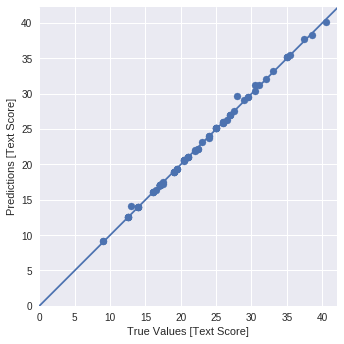

In [193]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Text Score]')
plt.ylabel('Predictions [Text Score]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

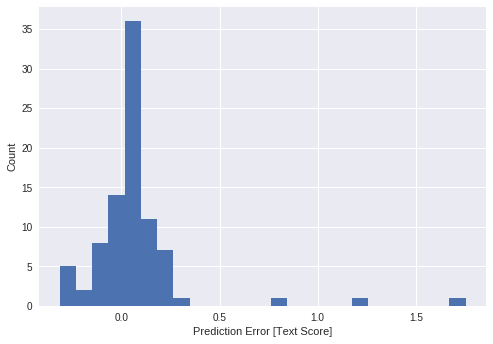

In [192]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Text Score]")
_ = plt.ylabel("Count")